In [1]:
# Copyright © 2018-2021 Intel Corporation All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#   * Redistributions of source code must retain the above copyright
#     notice, this list of conditions and the following disclaimer.
#   * Redistributions in binary form must reproduce the above copyright
#     notice, this list of conditions and the following disclaimer in
#     the documentation and/or other materials provided with the
#     distribution.
#   * Neither the name of Intel Corporation nor the names of its
#     contributors may be used to endorse or promote products derived
#     from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## Legal Information

This document contains the general insights and opinions of Intel Corporation (“Intel”). The information in this document is provided for information only and is not to be relied upon for any other purpose than educational. Intel makes no representations or warranties regarding the accuracy or completeness of the information in this document. Intel accepts no duty to update this document based on more current information. Intel is not liable for any damages, direct or indirect, consequential or otherwise, that may arise, directly or indirectly, from the use or misuse of the information in this document.

Intel technologies’ features and benefits depend on system configuration and may require enabled hardware, software or service activation. Learn more at intel.com, or from the OEM or retailer.

No computer system can be absolutely secure.  No license (express or implied, by estoppel or otherwise) to any intellectual property rights is granted by this document.  Intel, the Intel logo, Core, and Xeon are trademarks of Intel Corporation in the United States and other countries.  
*Other names and brands may be claimed as the property of others

Copyright © 2018-2021 Intel Corporation.

# Sequential Image Classifier with LSNNs

This tutorial shows how to use the sequential image classifier model. The sequential image classifier model is based on the Long short-term memory spiking neural network (LSNN) model which has the capability to preserve information for longer time spans during a computation, until it is needed or updated (<cite>[Bellec et al.][1]</cite>). Thus, such networks can be used for computations in the temporal domain, for which usually Long Short-Term Memory (LSTM) units are used in artificial neural netowrks. LSNNs incorporate adaptive neurons, which are capable to increase their firing threshold after preciding firing.


## LSNN architecture

The LSNN network is a recurrent network of spiking neurons. It consists of a neuron group of regular spiking LIF neurons (R) and neuron group of LIF neurons with adaptive thresholds (A). These neuron groups are connected to an input layer (X) and an output layer (Y).


The equation for the adaptive threshold and the network topology can be seen below:

<img src="files/figures/lsnn.png" width="800"> 

## Task: Sequential MNIST

Sequential MNIST refers to a classifcation task where the pixels of an image are presented sequentially, pixel by pixel. MNIST  (<cite>[LeCun et al.][2]</cite>)is the used image dataset. As the images have 28x28 pixels, an image is presented pixel by pixel over 784 time steps to the network. This means the network has to remember the input it got over 784 time steps in order to make a good classification.

### Training

This network was trained on conventional hardware using TensorFlow and a Loihi version of LSNNs utilizing back propagation through time (BPTT) and the ADAM optimizer (<cite>[Kingma et al.][3]</cite>). In addition Deep Rewiring (<cite>[Bellec et al.][4]</cite>) was used during the training to keep the connectivity sparse, in order to efficiently use this network on Loihi. After the training the determined weights can be transferred to the network on the Loihi chip. As the TensorFlow implementation already incorporates the contraints of Loihi, this transfer does not impair the performance from the training.

For the training the forward path uses quantized values suitable for Loihi and the backward pass uses full precision values to determine the weight updates. The process flow of the training can be seen below:

<img src="files/figures/train.png" width="400"> 

### The module

This is the high level view of the module which application will be shown in the following sections:
<img src="files/figures/module.png" width="900"> 

> **Host ... external CPU connected to Loihi  
> LMT ... embedded Lakemont processor (x86) on Loihi  
> NC ... neuromorphic cores**

[1]:https://arxiv.org/abs/1803.09574v4
[2]:http://yann.lecun.com/exdb/mnist/
[3]:https://arxiv.org/abs/1412.6980v9
[4]:https://arxiv.org/abs/1711.05136v5

In [2]:
%config IPCompleter.greedy=True
import sys
sys.path.append('/home/pplank/nxsdk-nxsdk/')
import os
import numpy as np
import matplotlib.pyplot as plt

import nxsdk.api.n2a as nx
from nxsdk_modules.lsnn.apps.seqmnist.seq_img_classifier import SequentialImageClassifierLsnn
from nxsdk_modules.lsnn.apps.seqmnist.seq_mnist import loadMnistData, loadWeightsAndDelays, showWeights, showImgs
from nxsdk_modules.lsnn.apps.seqmnist.benchmark.smnist_benchmark import performBenchmark, plotResultTable
from nxsdk.utils.env_var_context_manager import setEnvWithinContext

### Configuration of the network and loading of the data set and weights

According to the results of (<cite>[Bellec et al.][1]</cite>), 140 regular spiking neurons and 100 adaptive neurons are chosen for the recurrent network. The regular spiking neurons were further divided into excitatory (80) and inhibitory neurons (60). The adaptive neurons are all excitatory neurons. The input layer is defined with 80 neurons and 10 output neurons are chosen, corresponding to the 10 classes of the MNIST dataset.

An illustration of the network structure can be seen below:

<img src="files/figures/net.png" width="400"> 

The MNIST dataset and the weights are loaded from files. The weights were trainend with a TensorFlow LSNN model on conventional hardware, as described in the *Training* section. The training is not shown here, since it takes multiple hours to days - depending on the used hardware - to get decent classification performance. The number of input images and target labels are chosen randomly from the MNIST data according to the parameter numSamples.

[1]:https://arxiv.org/abs/1803.09574v4

In [3]:
def setupSequentialMnist(wgtDir, numSamples):
    """Sets up and executes SequentialImageClassifier LSNN network to\
    classify MNIST images on the test set.

    :param string wgtDir: directory which contains the weight matrices for\
    the network
    :param int numSamples: amount of images which should be processed
    :return: sqic, inputs, targets
    """

    # Specify data directory
    dataDir = os.path.join('/home/pplank/nxsdk-nxsdk/nxsdk_modules/lsnn/apps/seqmnist/weights', wgtDir)
    # MNIST images are 28 x 28 in size
    imgDx = imgDy = 28

    # Load input, recurrent and output layer weights
    wIn, wRec, wOut = loadWeightsAndDelays(dataDir)

    # Initialize LSSN network
    sqic = SequentialImageClassifierLsnn(wIn=wIn, wRec=wRec, wOut=wOut,
                                         numInput=80, numRegular=140,
                                         numAdaptive=100, numOutput=10,
                                         cueDuration=56,
                                         imageSize=imgDx * imgDy,
                                         batchSize=10)

    # Load a random set of MNIST test set images and pass to LSNN
    inputs, targets = loadMnistData('test')
    np.random.seed(5)
    imgIdx = np.random.choice(range(0, 10000), numSamples, False)
    inputs, targets = inputs[imgIdx, :], targets[imgIdx]
    
    # setup some probes
    probeParams = [nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE]
    probeParamsAux = [nx.ProbeParameter.COMPARTMENT_VOLTAGE]
    probeCond = [nx.IntervalProbeCondition(dt=1, tStart=83160), nx.SpikeProbeCondition(dt=1, tStart=82320)]
    probeCondAux = nx.IntervalProbeCondition(dt=1, tStart=83160)
    sqic._regularNeuronProbes = sqic.regularNeuronGroup.probe(probeParams, probeCond)
    sqic._adaptiveMainProbes = sqic.adaptiveMainCxGroup.probe(probeParams, probeCond)
    sqic._adaptiveAuxProbes = sqic.adaptiveAuxCxGroup.probe(probeParamsAux, probeCondAux)

    # recompile the network with probes
    sqic.generateNetwork()
    
    return sqic, inputs, targets

In [4]:
# name of the folder with the trainend weights
wgtDirName = 'v25_94per'


# numSamples range is 1 - 10000; batchSize must be a fraction of
# numSamples
sqic, inputs, targets = setupSequentialMnist(wgtDirName, numSamples=100)

### The trainend weight matrices

During training with the Deep Rewiring algorithm, an overall connectivity of 20% was chosen. Below the weight matrices are shown in detail. In the end the connectivity between the input layer and the recurrent layer ended up with 22.2% connectivity, the connectivity of the recurrent layer was 18.3% and the connectivity of the recurrent layer and the output layer was 35.2%.
Overall the connectivity was 19.8%.
This means that only 20% of the possible weights, need to be configured on Loihi which means that 80% less resources for synapses need to be used.

The illustration below shows the weight matrices. A blue color denotes a negative weight, white colors are zero weights and red colors represent postive weights. The split between excitatory (red, all positive or zero weights) and inhibitory neurons (blue, all negative or zero weights) which were fixed during training can also be noted in the recurrent matrix.

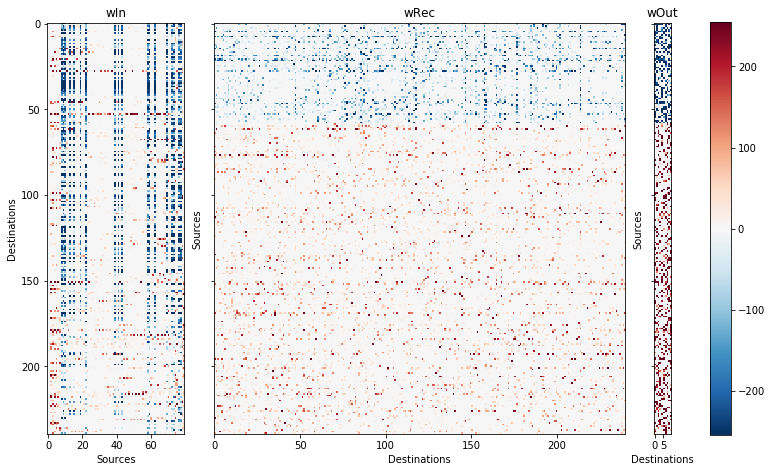

Connection matrix input -> recurrent: 22.2% density, 77.8% sparsity
Connection matrix recurrent -> recurrent: 18.3% density, 81.7% sparsity
Connection matrix recurrent -> output: 35.2% density, 64.8% sparsity
Connectivity overall: 19.8% density, 80.2% sparsity


In [5]:
# show weight matrices
showWeights(sqic._modelP.wIn, sqic._modelP.wRec, sqic._modelP.wOut)

# connectivity (non-zero weights)
# wIn
densityIn = np.round(100 - (np.sum(sqic._modelP.wIn == 0)/sqic._modelP.wIn.size) * 100, 1)
print("Connection matrix input -> recurrent: " + 
      str(densityIn) + "% density, " + str(100-densityIn) + "% sparsity")
# wRec
densityRec = np.round(100 - (np.sum(sqic._modelP.wRec == 0)/sqic._modelP.wRec.size) * 100, 1)
print("Connection matrix recurrent -> recurrent: " + 
      str(densityRec) + "% density, " + str(100-densityRec) + "% sparsity")
# wOut
densityOut = np.round(100 - (np.sum(sqic._modelP.wOut == 0)/sqic._modelP.wOut.size) * 100, 1)
print("Connection matrix recurrent -> output: " + 
      str(densityOut) + "% density, " + str(100-densityOut) + "% sparsity")
# overall
densityOverall = np.round(100 - ((np.sum(sqic._modelP.wIn == 0)+
                                        np.sum(sqic._modelP.wRec == 0)+
                                        np.sum(sqic._modelP.wOut == 0))/
                                        (sqic._modelP.wIn.size+
                                         sqic._modelP.wRec.size+
                                         sqic._modelP.wOut.size)) * 100, 1)
print("Connectivity overall: " + str(densityOverall) + "% density, " + str(100-densityOverall) + "% sparsity")

### The input images

Here are a few examples of the MNIST images as well as their target label.

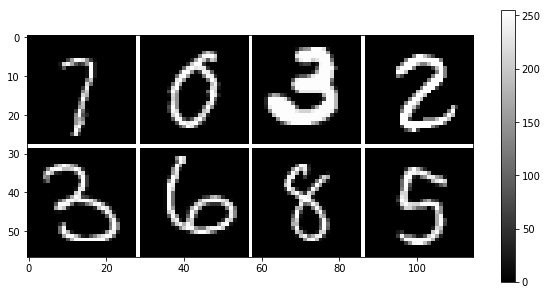

Targets: [7 0 3 2 3 6 8 5]


In [6]:
# show the input images
showImgs(inputs[0:8], 28, 28)

# show targets
print("Targets: " + str(targets[0:8]))

### Sequential images

This illustrates the pixel-by-pixel approach of providing the images to the network.

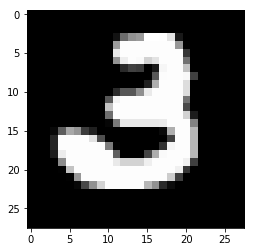

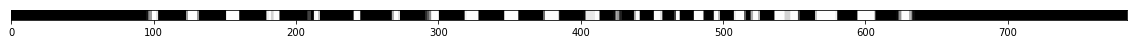

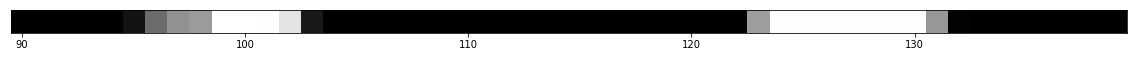

In [7]:
# show sequential image
img = np.reshape(inputs[2], (28, 28))

plt.figure()
plt.imshow(img, cmap="gray")
plt.show()

# whole pixel array
seq_img = []
for i in range(1,8):
    seq_img.append(inputs[2])

plt.figure(1, figsize=(20,20))
plt.imshow(seq_img, cmap="gray")
plt.yticks([])
plt.show()

# "zoomed" version
seq_img = []
for i in range(1,2):
    seq_img.append(inputs[2][90:140])

plt.figure(2, figsize=(20,20))
plt.imshow(seq_img, cmap="gray")
plt.yticks([])
plt.gca().xaxis.set_ticklabels([0,90,100,110,120,130])
plt.show()


### Encoding the images into spikes

The pixel values of the images need to be provided by spikes to the network. This is done using a threshold crossing algorithm, which generates threshold values depending on the number of input neurons and spikes if the pixel value crosses such a threshold when moving from one pixel to the next. The created thresholds are associated with the input neurons in the way that every threshold serves 2 input neurons - one for crossing the threshold from below and one for crossing it from above. In this example we have 80 input neurons and hence 40 thresholds.

If the pixel value exceeds its predecessor and also exceeds a new threshold, than every second input neuron, below the new threshold and above the old threshold, sends a spike. If the pixel value is lower than its predecessor and is lower than the previous threshold, then every other neuron inbetween the two thresholds sends a spike.

Example:
> The input pixels have values between 0 and 255. There are three thresholds A=20, B=80 and C=170, with 2 input neurons each,  meaning 6 total input neurons. The odd numbered input neurons are for input values exceeding the thresholds and the even input neurons are for input values falling below a threshold.
The first pixel has the value 0, it does not exceed any threshold, thus no input spikes occur.
The second pixel has the value 40, it does exceed threshold A, but not threshold B. Input neuron 1 sends a spike. The next pixel value is 180. It exceeds threshold B and C, therefore input neurons 3 and 5 send a spike. Input neuron 1 did not send a spike, as the previous value already exceeded threshold A. The next input pixel has the value 180. No spikes are produced, since no threshold is crossed with respect to the previous value. The next pixel has the value of 30. It falls under threshold B and C, thus input neurons 4 and 6 send a spike. The next pixel has the value 0 and therefore input neuron 2 send a spike.

The following code shows an implementation of this spike encoding as well as illustrating it with some figures. The time steps from 784 to 840 are denoted to a specific input neuron firing (input neuron 80) to inform the network, that all input pixels of one image have been presented and the classification should happen. This is not absolutely necessary, but was done in this example.

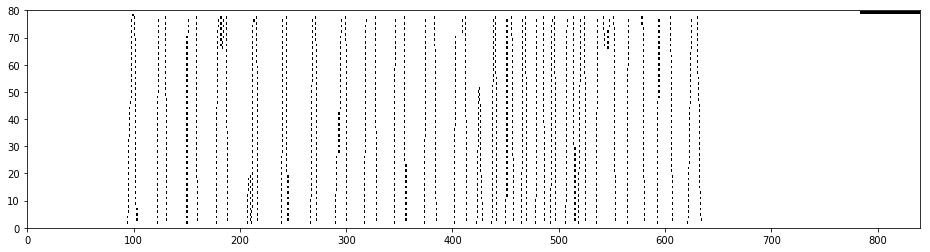

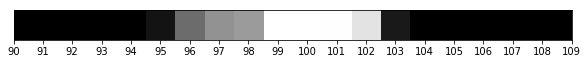

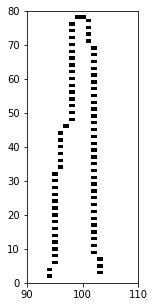

In [8]:
# spike encoding example
def find_onset_offset(y, threshold):
    """
    Given the input signal y with samples,
    find the indices where y increases and descreases through the value threshold.
    Return stacked binary arrays of shape y indicating onset and offset threshold crossings.
    y must be 1-D numpy arrays.
    """
    if threshold == 255:
        equal = y == threshold
        transition_touch = np.where(equal)[0]
        touch_spikes = np.zeros_like(y)
        touch_spikes[transition_touch] = 1
        return np.expand_dims(touch_spikes, axis=0)
    else:
        # Find where y crosses the threshold (increasing).
        lower = y < threshold
        higher = y >= threshold
        transition_onset = np.where(lower[:-1] & higher[1:])[0]
        transition_offset = np.where(higher[:-1] & lower[1:])[0]
        onset_spikes = np.zeros_like(y)
        offset_spikes = np.zeros_like(y)
        onset_spikes[transition_onset] = 1
        offset_spikes[transition_offset] = 1

    return np.stack((onset_spikes, offset_spikes))

# mnist image to input spikes
def img_to_spikes(input_px):
    """
    Converts MNIST images to spikes using a threshold crossing method.
    
    :param input_px: MNIST images data
    :return: spike data
    """
    numInput = 80

    # GENERATE THRESHOLD CROSSING SPIKES
    thrs = np.linspace(0, 255, numInput // 2)  # number of input neurons determins the resolution
    spike_stack = []
    for img in input_px:  # shape img = (784)
        Sspikes = None
        for thr in thrs:
            if Sspikes is not None:
                Sspikes = np.concatenate((Sspikes, find_onset_offset(img, thr)))
            else:
                Sspikes = find_onset_offset(img, thr)
        Sspikes = np.array(Sspikes)  # shape Sspikes = (31, 784)
        Sspikes = np.swapaxes(Sspikes, 0, 1)
        spike_stack.append(Sspikes)
    spike_stack = np.array(spike_stack)
    # add output cue neuron, and expand time for two image rows (2*28)
    out_cue_duration = 2*28
    spike_stack = np.lib.pad(spike_stack, ((0, 0), (0, out_cue_duration), (0, 1)), 'constant')
    # output cue neuron fires constantly for these additional recall steps
    spike_stack[:, -out_cue_duration:, -1] = 1

    return spike_stack

spikes = img_to_spikes([inputs[2]])
spikes = spikes[0]

plt.figure(3, figsize=(16,4))
plt.imshow(spikes.T, cmap="gray_r", aspect='auto')
plt.ylim(0, 80)

seq_img = []
for i in range(1,2):
    seq_img.append(inputs[2][90:110])
    
plt.figure(4, figsize=(10,1))
plt.imshow(seq_img, cmap="gray", aspect=1)
plt.yticks([])
plt.xticks(np.linspace(0, 20, 21))
plt.gca().xaxis.set_ticklabels(np.linspace(90, 110, 21, dtype=int))
plt.xlim(0, 19)

plt.figure(5, figsize=(2,5))
plt.imshow(spikes.T, cmap="gray_r", aspect='auto')
plt.ylim(0, 80)
plt.xlim(90,110)
plt.show()


### Classify the input

This is the line which starts the execution of the configured network on Loihi.

In [9]:
with setEnvWithinContext(PARTITION="nahuku08"):
    # Execute network: Generates spikes from images and injects into LSNN
    sqic.classify(inputs, targets)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:35859
INFO:DRV:      Host server up..............Done 0.21s
INFO:DRV:      Encoding axons/synapses.....Done 0.05s
INFO:DRV:      Compiling Embedded snips....Done 0.36s
INFO:DRV:      Encoding probes.............Done 0.98ms
INFO:DRV:      Booting up..................Done 2.59s
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring probes.........Done 0.05s
INFO:DRV:      Transferring spikes.........Done 0.65ms
[==========] 100%
INFO:DRV:      Executing...................Done 3.40ms
INFO:DRV:      Processing timeseries.......Done 1.83s


### Activity of the network

This shows some examples of the activity during the execution. Since probing everything would slow down the execution, only the last image has been probed and the membrane potentials and activity of the regular and adaptive neurons are illustrated here as well as the adaption of the thresholds of the adaptive neurons.

The adaptive threshold is implemented with a 2 compartment neuron. The membrane potential of the auxiliary compartment is substracted from the membrane potential in the main compartment, thus increasing the margin between the membrane potential and the threshold. Every time the main compartment produces a spike, the spike gets also sent to the auxiliary compartment which decreases its membrane potential.

Here the comparisson between the original version and the implemented version on Loihi:

<img src="files/figures/athr.png" width="1000"> 

The time constant for the adaptive threshold defines the time it takes the threshold of an adaptive neuron, after it spiked, to fall back to the baseline threshold level, if no additional spiking occurs. In this example the time constant is set to 700 time steps. Furthermore, this time constant represents the duration of the adaptive neuron to remember a previous input. The memory of an LSNN is located in the adaptive thresholds of the adaptive neurons. This concept is also efficent, since the information is saved within a lower spiking activity of the adaptive neurons. 


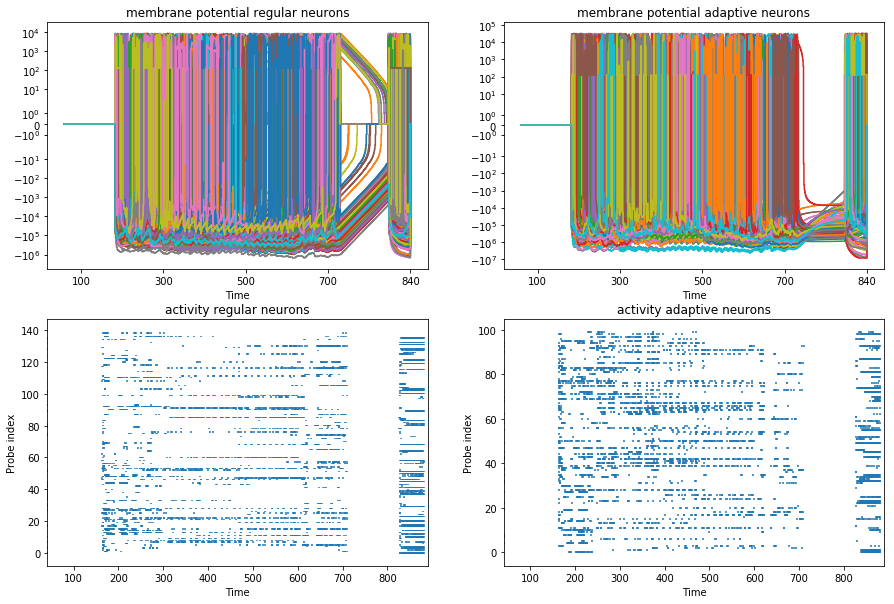

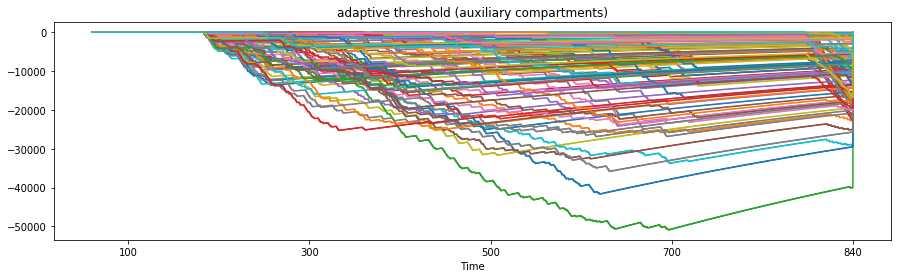

In [10]:
# show activity, thresholds

plt.figure(4, figsize=(15,10))
plt.subplot(2,2,1)
sqic.regularNeuronProbes[0].plot()
plt.yscale('symlog')
plt.gca().xaxis.set_ticklabels([0,100,300,500,700,840])
plt.title("membrane potential regular neurons")

plt.subplot(2,2,2)
sqic.adaptiveMainProbes[0].plot()
plt.yscale('symlog')
plt.gca().xaxis.set_ticklabels([0,100,300,500,700,840])
plt.title("membrane potential adaptive neurons")

plt.subplot(2,2,3)
sqic.regularNeuronProbes[1].plot()
plt.xlim(841,1690)
plt.gca().xaxis.set_ticklabels([0,100,200,300,400,500,600,700,800,900])
plt.title("activity regular neurons")

plt.subplot(2,2,4)
sqic.adaptiveMainProbes[1].plot()
plt.xlim(841,1690)
plt.gca().xaxis.set_ticklabels([0,100,200,300,400,500,600,700,800,900])
plt.title("activity adaptive neurons")

plt.figure(6, figsize=(15,4))
sqic.adaptiveAuxProbes[0].plot()
plt.gca().xaxis.set_ticklabels([0,100,300,500,700,840])
plt.title("adaptive threshold (auxiliary compartments)")
plt.show()

### Results

This shows the classification results in this example. It also shows the misclassified images and their target label.

Classification accuracy of 100 samples: 95.00%


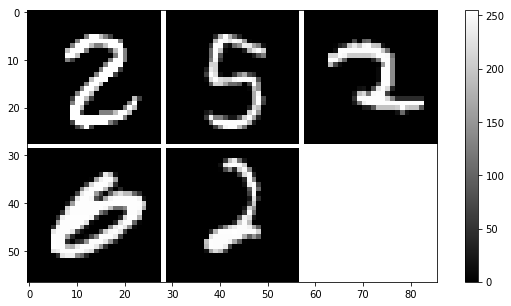

Target labels:  [2 5 2 0 2]
Predicted labels:  [3 3 5 6 1]


In [11]:
# Show results
sqic.printClassification()

# some wrong classifications
# get idx of misclassified images
idx_list = np.where(targets != sqic.classifications)[0]

# show the target images
target_img = inputs[idx_list]

showImgs(target_img, 28, 28)
print("Target labels: ", targets[idx_list])
print("Predicted labels: ", sqic.classifications[idx_list])

### Results: Accuracy, Energy, Latency, Throughput

In the following section a benchmark run is done to determine the execution time as well as the power and energy consumption of this example. In the end it produces a table for the given board type.


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.93:39529
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Compiling Embedded snips....Done 0.30s
INFO:DRV:      Encoding axons/synapses.....Done 0.05s
INFO:DRV:      Encoding probes.............Done 0.08ms
INFO:DRV:      Booting up..................Done 0.48s
INFO:DRV:      Configuring registers.......Done 0.03s
INFO:DRV:      Transferring probes.........Done 5.03ms
INFO:DRV:      Transferring spikes.........Done 0.29ms
[==========] 100%
INFO:DRV:      Executing...................Done 0.01s
INFO:DRV:      Processing timeseries.......Done 0.02s
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.93:41841
INFO:DRV:      Host server up..............Done 0.17s
INFO:DRV:      Encoding axons/synapses.....Done 0.42s
INFO:DRV:      Compiling Embedded snips....Done 0.35s
INFO:DRV:      Booting up..................Done 0.48s
INFO:DRV:      Encoding probes.............Do

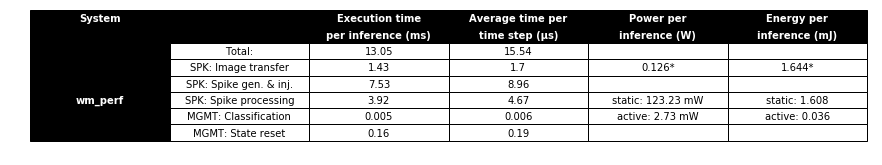

In [12]:
# benchmark run
numSamples = 100
wgtDirName = 'v25_94per' # name of the folder with the trainend weights
numCores = [1, 10, 40]
partitions = ["wm_perf"]
resultList = performBenchmark(wgtDirName, numSamples, partitions, numCores)

# plot the results
for results in resultList:
    plotResultTable(results)

plt.show()

#### Comparison to conventional hardware

Comparision of the results from Loihi with conventional hardware on the same task and a comparable ANN (single layer LSTM network with 128 units). 

<img src="files/figures/bench.png" width="800"> 


\* Performance results are based on testing as of June 2019 and may not reflect all publicly available security updates. No product can be absolutely secure.  
Platform testing details:

| <p align="left"> System                          | <p align="left"> Configuration                                                                 |
|--------------------------------------------------|------------------------------------------------------------------------------------------------|
| <p align="left"> Loihi                           | <p align="left"> Loihi Wolf Mountain & Nahuku32 platform running NxSDK v0.85.                  |
| <p align="left"> Intel Core i5-7440HQ            | <p align="left"> CPU 2.8-3.8 GHz with 16 GB RAM. OS: Windows 10. TensorFlow v1.14.1.           |
| <p align="left"> Intel Core i7-7700HQ            | <p align="left"> CPU 2.8-3.8 GHz with 16 GB RAM. OS: Windows 10. TensorFlow v1.14.1.           |
| <p align="left"> Intel Core i7-4790              | <p align="left"> CPU 3.6-4.0 GHz with 32 GB RAM. OS: Ubuntu 4.4.0-143. TensorFlow v.1.14.1.    |
| <p align="left"> [NVIDIA GeForce GTX 1050 Ti][1] | <p align="left"> 4GB RAM, CUDA v10.0. Driver v419.17. OS Windows 10. TensorFlow v1.13.1        |
| <p align="left"> [NVIDIA Tesla P100][2]          | <p align="left"> 16GB RAM, CUDA v10.2. Driver v430.26. OS Debian Linux 9.9. TensorFlow v1.10.1 |


| <p align="left"> Algorithm | <p align="left"> Training Methodology                                                                                                                                                                     |
|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| <p align="left"> LSNN      | <p align="left"> Backprop  ([Adam][3]) +  [DeepRewiring][4],  TensorFlow  v1.5.                                                                                                     |
| <p align="left"> LSTM      | <p align="left"> Backprop  ([Adam][3]),  TensorFlow  v1.14.1, LSTM model:  tf.keras.layers.lstm   ([Hochreiter  et al.][5]) |
    
    

[1]: https://www.geforce.com/hardware/desktop-gpus/geforce-gtx-1050-ti/specifications
[2]: https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/tesla-p100/pdf/nvidia-tesla-p100-datasheet.pdf
[3]: https://arxiv.org/abs/1412.6980
[4]: https://arxiv.org/abs/1711.05136v5
[5]: https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735
